Here I am using Haleigh Miller's platemappy code but adjusted it to my BWF cohort. 

Authors: ChatGPT and Sophie Porak

In [ ]:
import pandas as pd 
import random 
import numpy as np 
import math 
import matplotlib.pyplot as plt 
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.lines as mlines

def chunks(lst, n):
    """
    Split list 'lst' into n (as even as possible) chunks. 
    Returns a list of lists with length n. Some may differ by max 1 element.

    This function ensures that data gets split into chunks/groups as evenly as possible! 
    """
    n = max(1, n)
    q, r = divmod(len(lst), n) #returns quotient and remainder e.g. divmod(5, 2) = (2, 1), as 2 x 2 + 1 = 5
    out = []
    start = 0
    for i in range(n):
        size = q + (1 if i < r else 0)
        out.append(lst[start:start+size])
        start += size 
    return out


class Metadata:
    """
    Plate map generator that support any number of sample groups.

    Parameters:
    ----------
    X : pd.DataFrame. 
        This is the metadata table. Index must be unique sample IDs (strings).

    group_col : str
        Column that holds the category label for each sample.
        Examples: 'History of BWF' 'Incident F1' 'control' etc.

    n_ag : int
        Number of AG controls per plate

    n_canary : int 
        Number of Canary control wells per plate

    n_mAb : int 
        Count of mAb controls per plate.

    duplicate_ : int 
        Number of technical duplicates per sample (e.g. 2 means duplicates for each sample)

    block_ : int, default 0
        Size of a contriguous block of wells to insert (filled with 'HC')
    
    block_column_ : list[int], default []
        Zero-based column indices to block entirely (0..11). Blockers filled with 0. 
    
    block_row_ : list[int], default []
        Zero-based row indices to block entirely (0..7). Blockers filled with 0. 

    Attributes
    -----------
    k : int
        Number of plates
    
    cats : list[str]
        Ordered list of unique group labels found in X[group_col]

    """
    
    def __init__(
            self, 
            X : pd.DataFrame, 
            group_col: str, 
            n_ag: int, 
            n_canary: int, 
            n_mAb: int, 
            duplicate_: int, 
            block_ = 0, 
            block_column_ = None, 
            block_row_ = None, 
    ) -> None: 
        if block_column_ is None: block_column_ = []
        if block_row_ is None: block_row_ = []

        assert X.index.is_unique, "X.index (sample IDs) must be unique."
        assert group_col in X.columns, f"{group_col} not in X.columns"

        self._X = X.copy()
        self._group = group_col 
        self._ag = int(n_ag)
        self._can = int(n_canary)
        self._mab = int(n_mAb)
        self._block = int(block_)
        self._dup = int(duplicate_)
        self._blockcol = list(block_column_)
        self._blockrow = list(block_row_)

        #categories (groups) present in metadata 
        self.cats = list(self._X[self._group].astype(str).unique())

        self.k = self._init_params()

    def _init_params(self) -> int:
        """
        Compute the number of plates given controls + blocks.
        """
        x = (
            self._ag + self._can + self._mab
            + self._block 
            + 12 * len(self._blockcol)
            + 12 * len(self._blockrow)
        )

        usable = max(0, 96 - x) #forces result to be at least 1
        total_samples = self._X.shape[0] * (self._dup if self._dup else 1)
        #the idea is to find out how many plates you need to hold all of your samples including the above considerations.
        k = math.ceil(total_samples / usable) if usable else math.ceil(total_samples / 1) #math.ceil rounds number up to nearest integer. e.g. math.ceil(4.2) = 5. in this case ensures there are enough slots / wells.
        return max(1, k) #forces result to be at least 1
    
    # ------- Allocation Method -----

    def allocate_samples_to_plate(self) -> dict: #arrow indicates that this function is expected to return a dictionary
        """
        Distribute samples to plates while preserving per-group balance. 
        Strategy: for each group, shuffle the samples and then split into k chunks(so number of plates) as even as possible. 
        then mix these chunks across plates. 
        """
        #generates number from 0 up to self.k - 1 and shifts number to start at 1 instead at 0 (with i + 1). each key maps to an empty list. so if you have e.g. 3 plates, then 
        #you would have 1, 2, 3 mapping to (for now) empty lists. Samples will then be appended to the corresponding list later. 
        samples_to_plates = {i + 1: [] for i in range(self.k)}

        #Built list of samples for each group (with duplication if requested)
        for group in self.cats:
            samples_g = self._X.index[self._X[self._group] == group].tolist()
            if self._dup and self._dup > 1: 
                #duplicate each sample self._dup times 
                samples_g = [s for s in samples_g for _ in range(self._dup)] 
            
            random.shuffle(samples_g)
            split = chunks(samples_g, self.k) #list of length k, where samples from each group get distributed across number of plates k as evenly as possible. 
            for i in range(self.k):
                samples_to_plates[i + 1].extend(split[i]) #extend differs from append, as it takes an iterable such as another list and adds each element individually. flattens one level. needed as we start off with an empty list.  

        #a final suffle per plate to intermix groups more   
        for i in range(self.k):
            random.shuffle(samples_to_plates[i + 1])
        
        return samples_to_plates

    def allocate_samples_alt(self) -> dict: 
        """
        Alternative allocator: round-robin assignment across plates per group. 
        """
        samples_to_plates = {i + 1: [] for i in range(self.k)} #again, creating empty lists as values to each key (plate number)

        #for each group, shuffle and then place items round-robin by plate
        for group in self.cats:
            samples_g = self._X.index[self._X[self._group] == group].tolist()
            if self._dup and self._dup > 1: 
                samples_g = [s for s in samples_g for _ in range(self._dup)]
            random.shuffle(samples_g)

            plate_idx = 0
            for s in samples_g:
                samples_to_plates[plate_idx + 1].append(s) # to each plate, append the randomly shuffled samples of each group. 
                plate_idx = (plate_idx + 1) % self.k #moves it to next plate. % self.k wraps it around when you reach the last plate. Because 3 / 3 = 1 with remainder 0. for 2 / 3, 3 fits zero times but the remainder is 2. 


        #Optional shuffle
        for i in range(self.k):
            random.shuffle(samples_to_plates[i+1])
        
        return samples_to_plates

    def create_plates(self, samples_to_plates: dict) -> dict: 
        """
        Creates plate matrices (8 x 12) with sample IDs and controls. 
        Returns dict: {plate_number: np.ndarray shape (8,12)}
        """
        # Flat indices for the last two wells with row-major A1..H12 order:
        # H11 -> 7*12 + 10 = 94, H12 -> 7*12 + 11 = 95
        last_two_idxs = [94, 95]

        # sanity: if you want both last wells to be Canary, you should have at least 2 per plate
        if self._can < 2:
            raise ValueError("n_canary must be >= 2 to keep Canary in the last two wells.")

        plates = {}

        for i in range(1, self.k + 1):
            # Make a fresh list so we don't mutate the input dict
            samples = list(samples_to_plates[i])

            # Controls
            AG = ['AG'] * self._ag
            mAb = ['mAb'] * self._mab

            # Reserve two Canaries for the last two wells; put any *extra* Canaries into the pool
            can_end = 2
            can_rest = max(0, self._can - can_end)

            pool = samples + AG + (['Canary'] * can_rest) + mAb
            random.shuffle(pool)

            # Contiguous block (kept as 'HC' per your code; switch to 0 if you prefer empty)
            if self._block > 0: 
                insert_loc = random.randint(0, max(0, 96 - self._block))
                pool[insert_loc:insert_loc] = ['HC'] * self._block

            # Entire blocked rows filled with 0 
            for r in sorted(self._blockrow):
                insert_loc = r * 12
                pool[insert_loc:insert_loc] = [0] * 12

            # Entire blocked columns filled with 0 
            for c in sorted(self._blockcol):
                for rr in range(7, -1, -1):  # bottom to top to avoid index shifting
                    insert_loc = rr * 12 + c
                    pool[insert_loc:insert_loc] = [0]

            # ensure exactly 96 wells
            if len(pool) < 96:
                pool.extend([0] * (96 - len(pool)))
            if len(pool) > 96:
                pool = pool[:96]

            # >>> Force Canary into the last two wells <<<
            # NOTE: Don't block row H (r=7) or columns 11/12 (c=10/11) if you want this to hold.
            pool[last_two_idxs[0]] = 'Canary'  # H11
            pool[last_two_idxs[1]] = 'Canary'  # H12

            plates[i] = np.reshape(pool, (8, 12))

        return plates

        
    def save_plates(self, plates, base_path) -> None:
        """
        Save plate CSVs: plate_1.csv, plate_2.csv etc
        """

        for p in plates: 
            X = plates[p]
            df = pd.DataFrame(
                data=X, 
                columns=[str(i) for i in range (1, 13)],
                index = list("ABCDEFGH")
            )
            df.to_csv(f"{base_path}plate_{p}.csv")
        return None

     # -------- Visualization --------

    def view_plate(self, plate, view_bin=False, key=True, key_dict=None, save=False, save_loc=None) -> None:
        """
        Visualize a plate layout.

        Parameters
        ----------
        plate : np.ndarray (8,12)
            Plate matrix returned by create_plates().
        view_bin : bool
            If True, draw the numeric-coded matrix; otherwise draw sample IDs / control labels in cells.
        key : bool
            Whether to include a legend. (Recommended True.)
        key_dict : dict or None
            Optional mapping from group label -> nice display label in legend.
        save : bool
            Save the figure.
        save_loc : str or None
            Path used when save=True.
        """
        fig, ax = plt.subplots(figsize=(15, 10))

        # Category  color index
        n_cats = len(self.cats)
        cat_to_idx = {cat: i for i, cat in enumerate(self.cats)}

        # Sample ID  category index
        # (We convert to str to be safe with mixed index types)
        sample_to_cat_idx = {
            str(sid): cat_to_idx[str(self._X.loc[sid, self._group])]
            for sid in self._X.index
        }

        # Controls get indices AFTER the categories
        CONTROL_LABELS = ['AG', 'Canary', 'mAb', 'control', 'Repeated', 'HC']
        control_to_idx = {lab: n_cats + i for i, lab in enumerate(CONTROL_LABELS)}
        MISSING_IDX = n_cats + len(CONTROL_LABELS)  # index for empty/blocked wells (0)

        # Build a lookup that maps: sampleID/controls/0  -> integer index
        def lookup(val):
            if isinstance(val, (int, float)) and val == 0:
                return MISSING_IDX
            sval = str(val)
            if sval in sample_to_cat_idx:
                return sample_to_cat_idx[sval]
            if sval in control_to_idx:
                return control_to_idx[sval]
            return MISSING_IDX

        bin_plate = np.vectorize(lookup)(plate)

        # Colors: categories + controls + missing
        default_colors = [
            'lightcyan','green','blue','deepskyblue','dodgerblue','seagreen',
            'aquamarine','cornflowerblue','plum','orchid','lightgreen','lightsalmon'
        ]
        # ensure we have enough colors
        need = n_cats + len(CONTROL_LABELS) + 1
        if len(default_colors) < need:
            # extend with a repeating simple palette (not fancy, but robust)
            more = (default_colors * ((need // len(default_colors)) + 1))[:need - len(default_colors)]
            default_colors = default_colors + more

        cmap_ = ListedColormap(default_colors[:need])
        # boundaries for each integer label (0..need-1)
        bounds = np.arange(-0.5, need + 0.5, 1)
        norm_ = BoundaryNorm(bounds, cmap_.N)

        # Draw grid, labels
        for i in range(8):
            for j in range(12):
                text_val = bin_plate[i, j] if view_bin else plate[i, j]
                ax.text(j, i, text_val, va='center', ha='center', fontsize=9)
                ax.vlines(j + 0.5, ymin=-.5, ymax=8.5, color='black', linewidth=0.5)
                ax.hlines(i + 0.5, xmin=-.5, xmax=12.5, color='black', linewidth=0.5)

        # Legend
        if key:
            handles_ = []
            # sample categories
            for k, cat in enumerate(self.cats):
                label_ = key_dict.get(cat, cat) if key_dict else cat
                handles_.append(
                    mlines.Line2D([], [], color=default_colors[k], marker='s',
                                  linestyle='None', markersize=10, label=label_)
                )
            # controls
            for i, lab in enumerate(CONTROL_LABELS):
                idx = n_cats + i
                handles_.append(
                    mlines.Line2D([], [], color=default_colors[idx], marker='s',
                                  linestyle='None', markersize=10, label=lab)
                )
            # missing/blocked wells
            handles_.append(
                mlines.Line2D([], [], color=default_colors[MISSING_IDX], marker='s',
                              linestyle='None', markersize=10, label='Empty/Blocked')
            )

            plt.legend(handles=handles_, bbox_to_anchor=(1.05, 1),
                       loc='upper left', borderaxespad=0.)

        ax.matshow(bin_plate, cmap=cmap_, norm=norm_)

        ax.set_xticks(range(12))
        ax.xaxis.tick_top()
        ax.set_xticklabels([str(i) for i in range(1, 13)], fontsize='x-large')

        ax.set_yticks(range(8))
        ax.set_yticklabels(list("ABCDEFGH"), fontsize='x-large')

        if save and save_loc:
            plt.savefig(save_loc, bbox_inches='tight')
            


In [12]:
import os, pandas as pd, numpy as np, random

# (optional) reproducibility
random.seed(42); np.random.seed(42)

# Load your CSV: must have columns ['sample_id','status'] (rename to match)
X = pd.read_csv("BWF_samples_for_platemappy_randomizer.csv")     # <-- change path
X = X.rename(columns={'your_group_col': 'Category', 'your_id_col': 'Sample_ID'})  # if needed
X = X.astype({'Category': 'string'})
X = X.set_index('Sample_ID', drop=True)

print(X['Category'].value_counts())     # quick sanity check




Category
History of BWF       202
No history of BWF    195
Incident F1           28
control               24
Incident F2           23
Repeated               3
Name: count, dtype: Int64


In [13]:
#Instantiate the class
md = Metadata(
    X=X, 
    group_col='Category',
    n_ag = 4, 
    n_canary = 2, 
    n_mAb = 2, 
    duplicate_ = 2, 
    block_ = 0, 
    block_column_ = [],
    block_row_ = []
)
print("Plates needed", md.k)

Plates needed 11


In [14]:
alloc = md.allocate_samples_to_plate()

plates = md.create_plates(alloc)

# 2) Sanity-check you really have a dict of arrays
print(type(plates), len(plates))        # should be <class 'dict'> and >0
for k, arr in plates.items():
    print(k, getattr(arr, 'shape', None))  # each should be (8, 12)

<class 'dict'> 11
1 (8, 12)
2 (8, 12)
3 (8, 12)
4 (8, 12)
5 (8, 12)
6 (8, 12)
7 (8, 12)
8 (8, 12)
9 (8, 12)
10 (8, 12)
11 (8, 12)


Plate 1
Plate 2
Plate 3
Plate 4
Plate 5
Plate 6
Plate 7
Plate 8
Plate 9
Plate 10
Plate 11


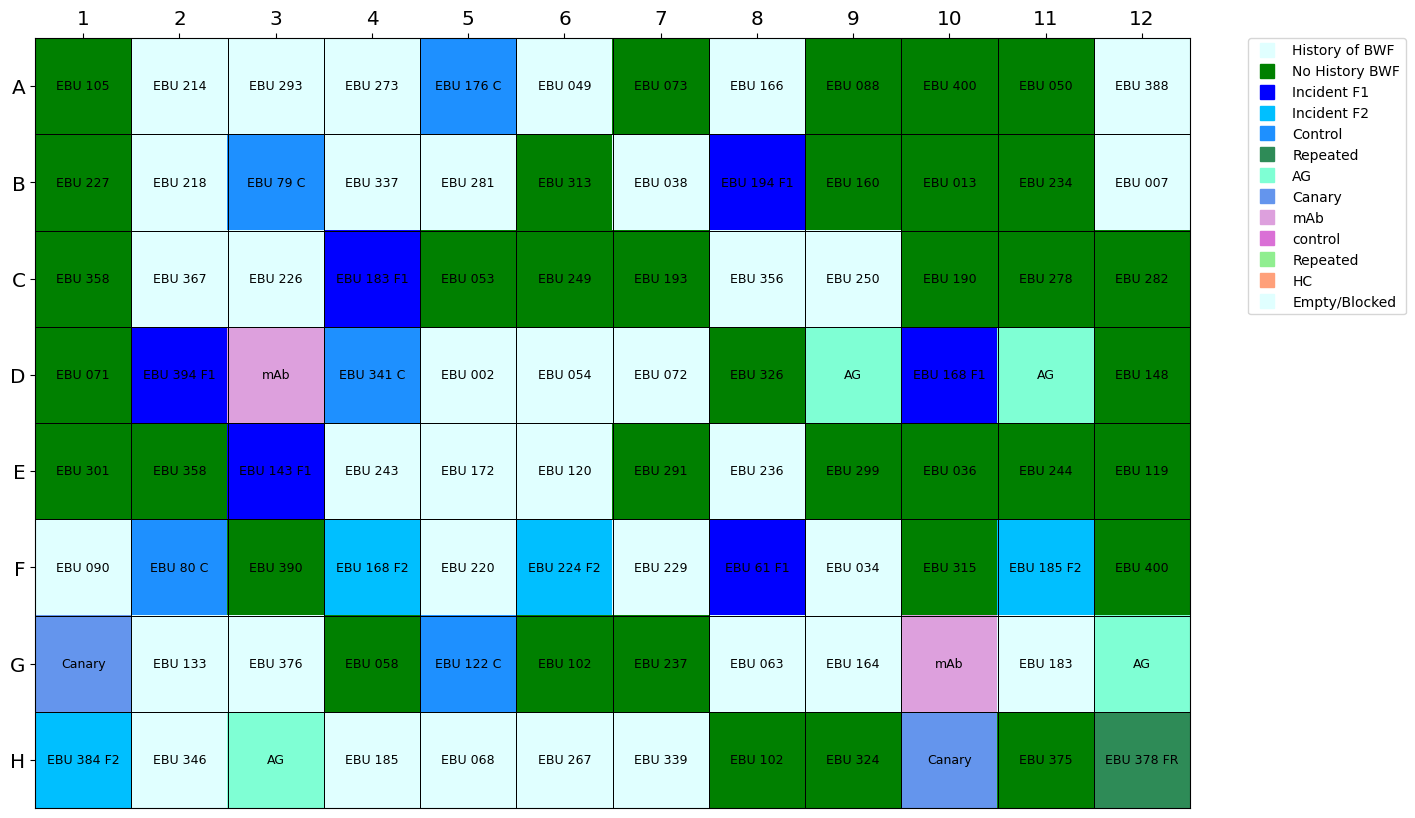

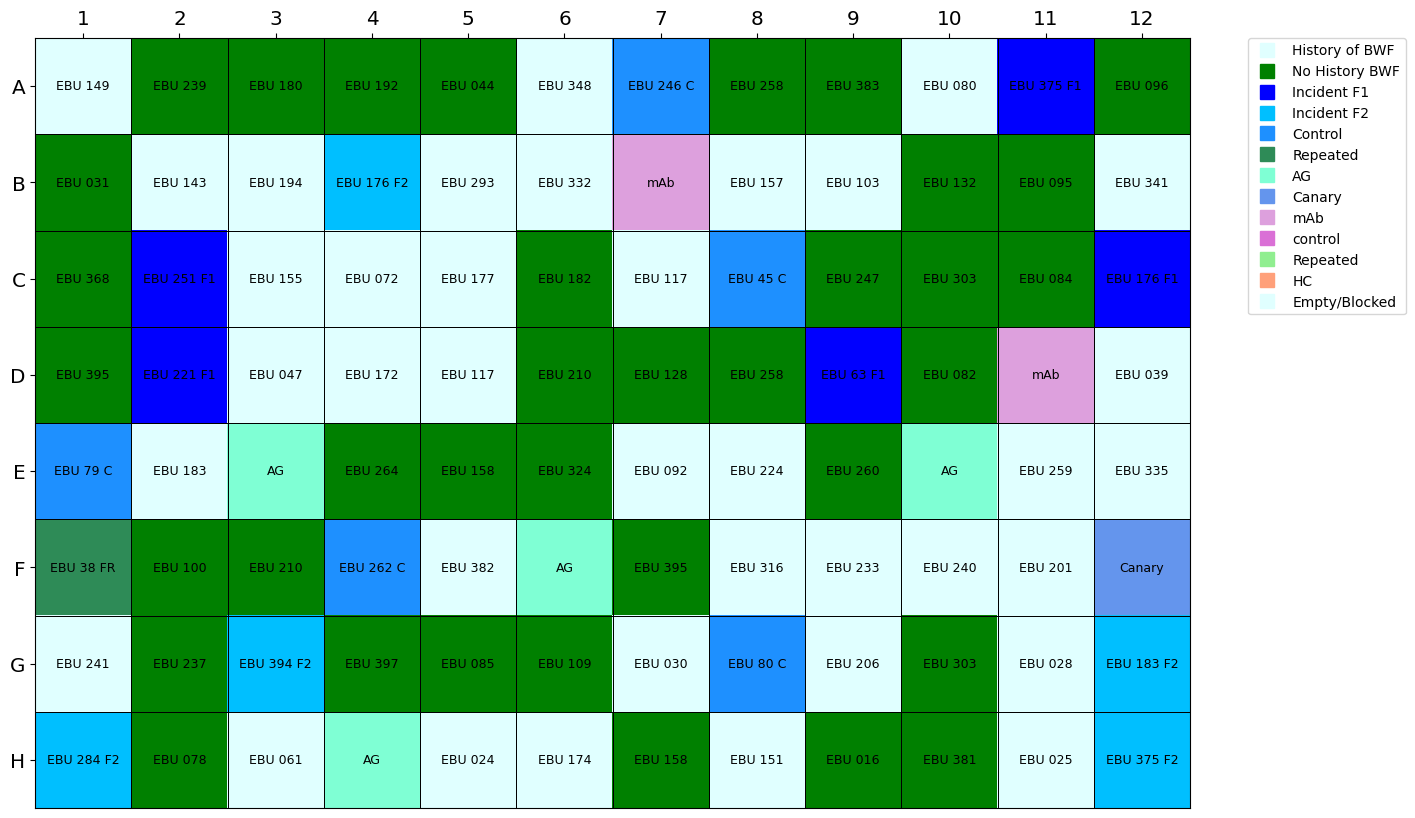

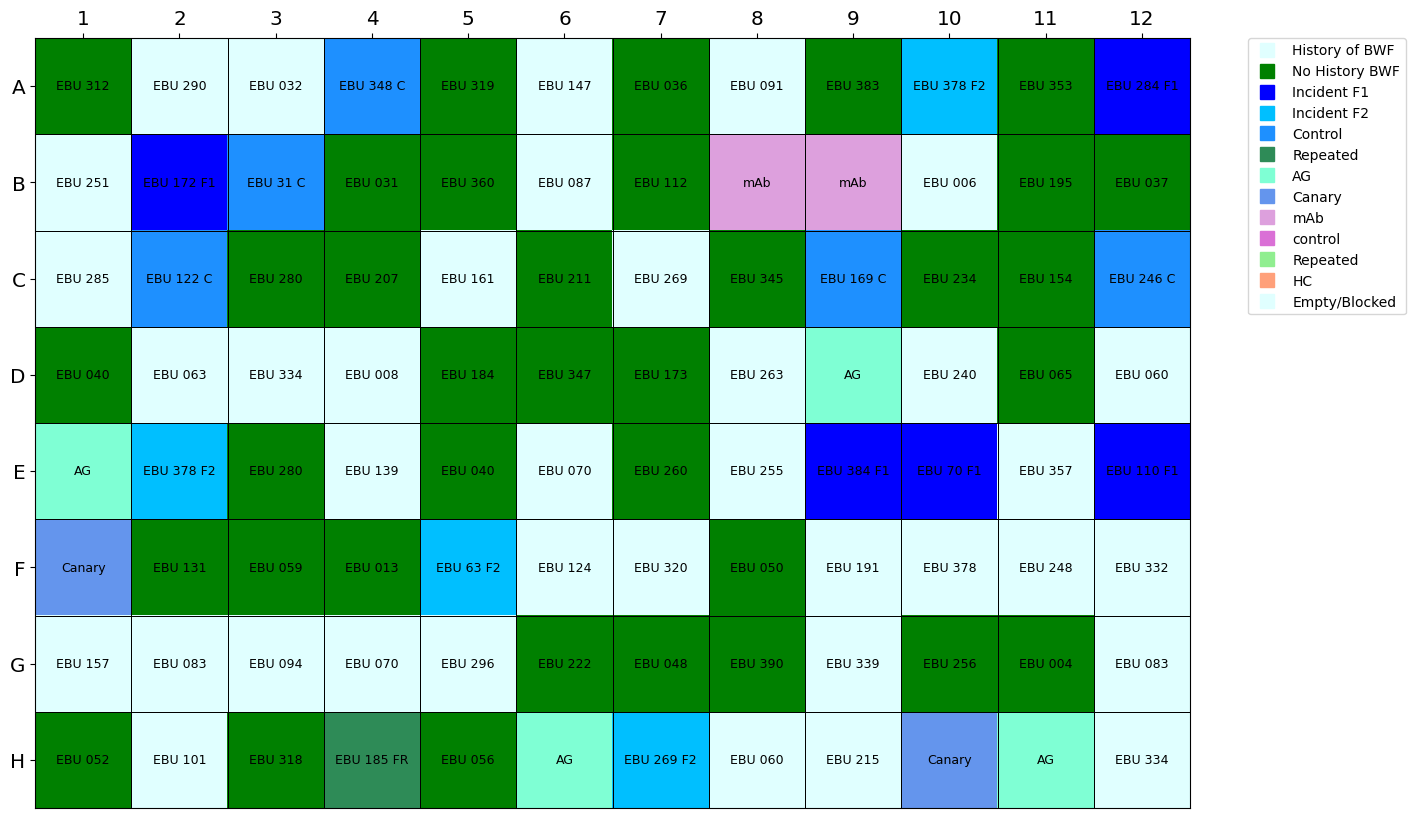

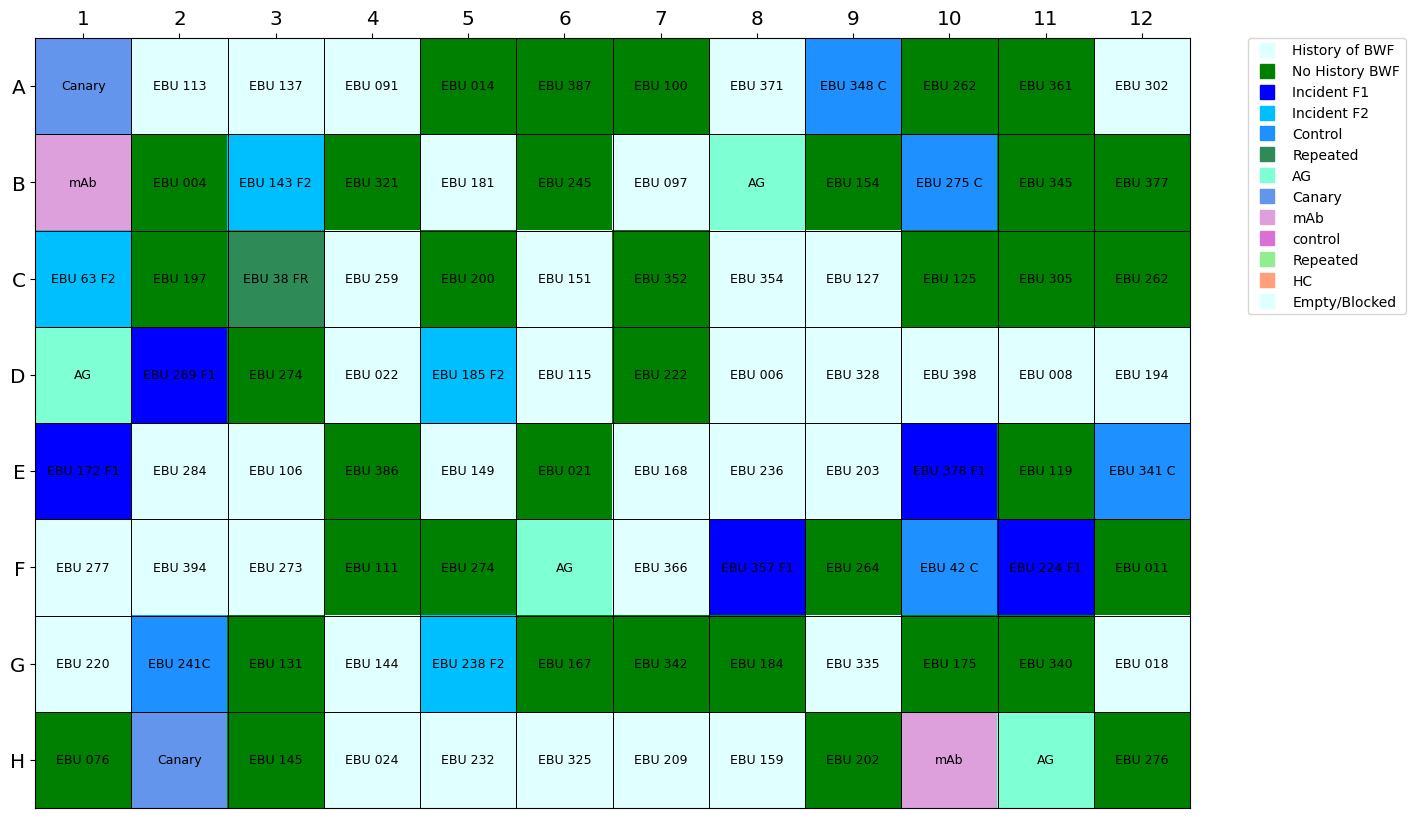

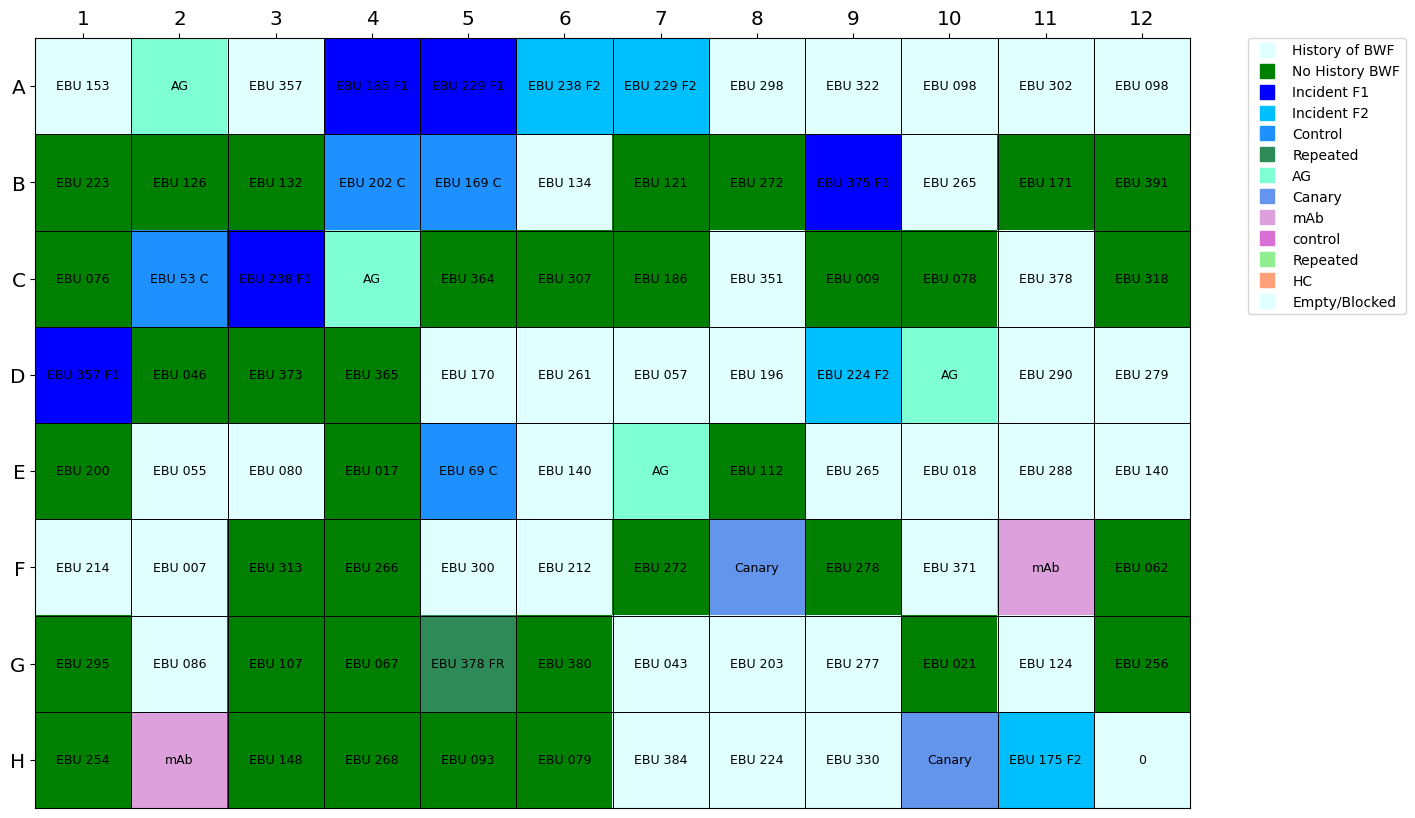

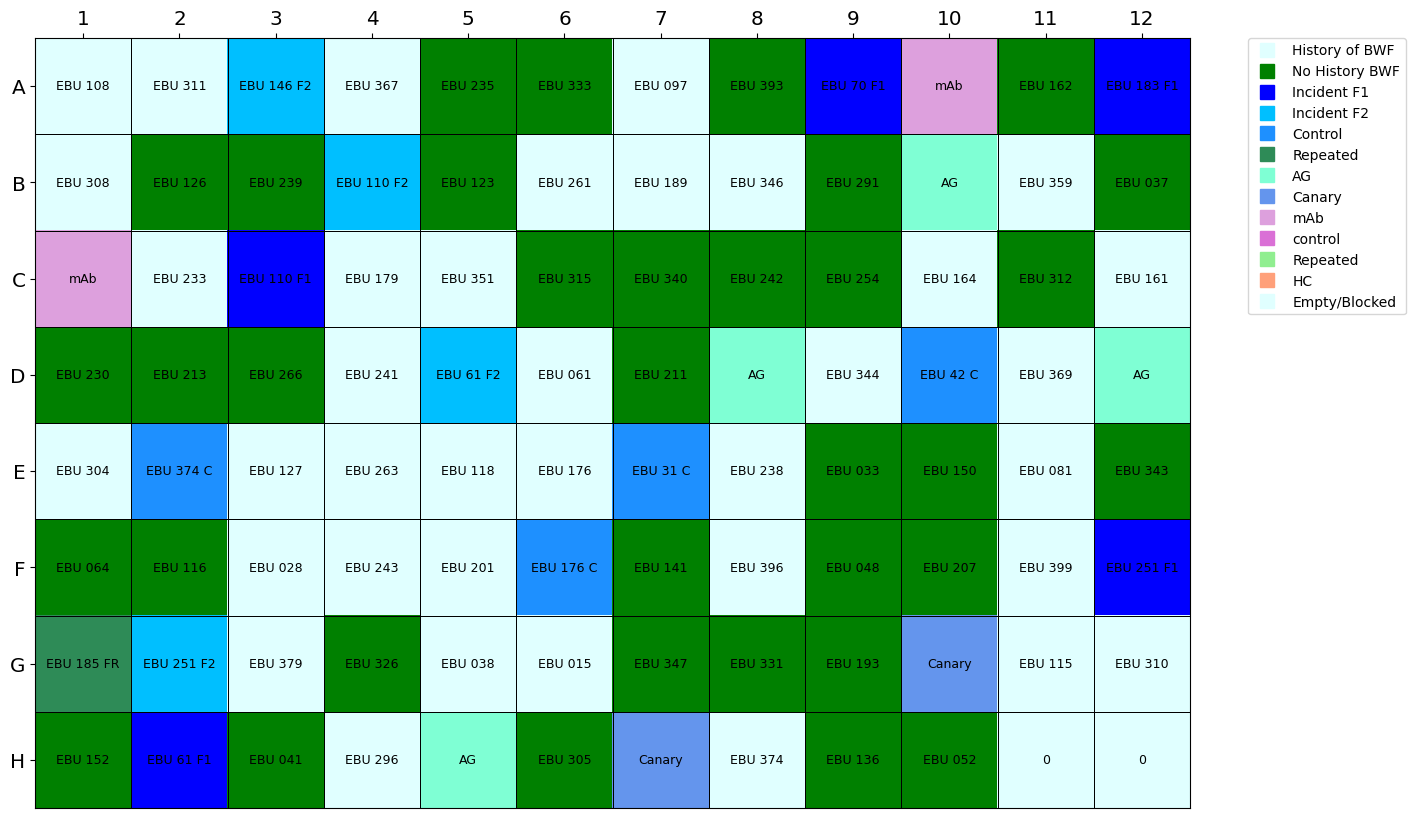

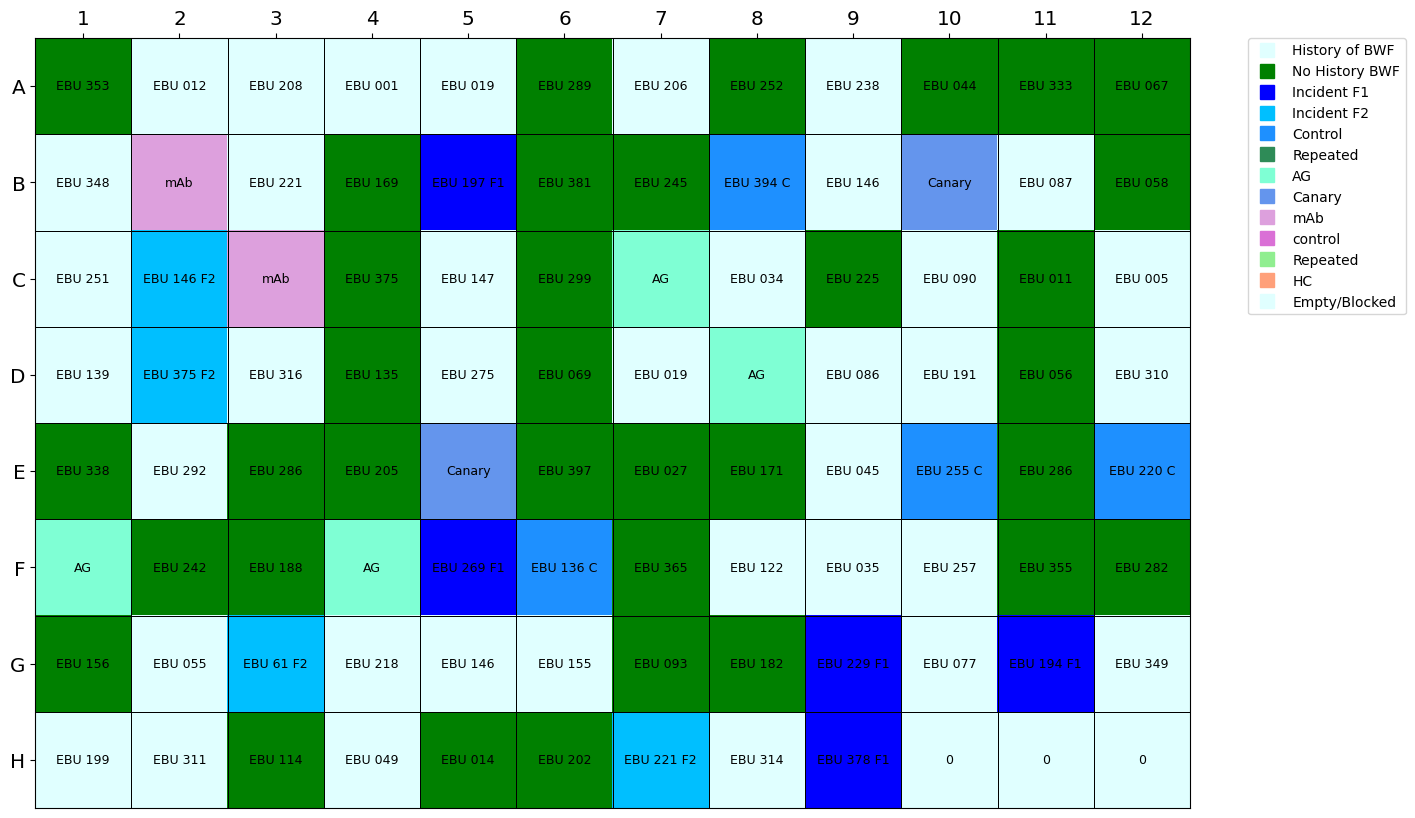

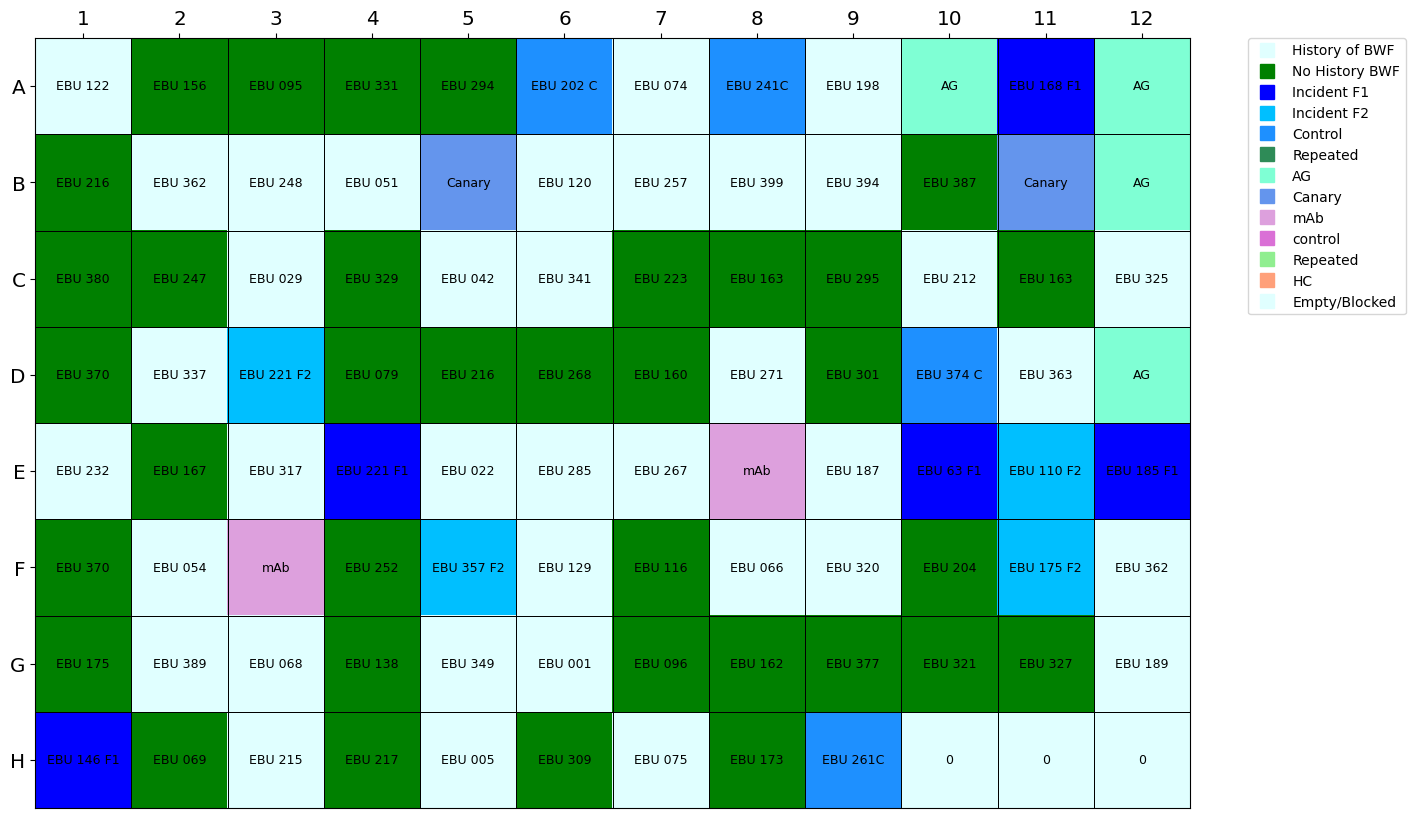

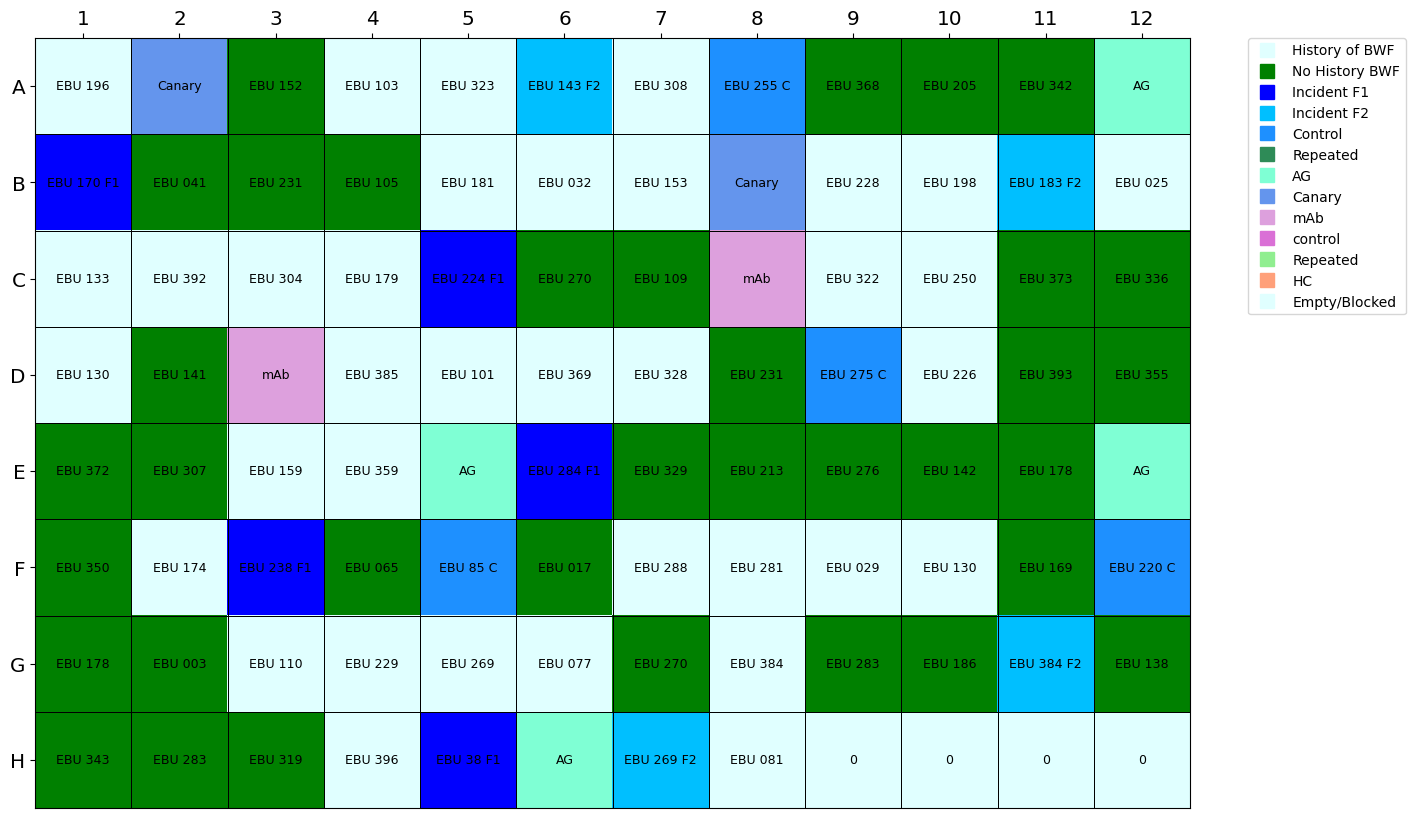

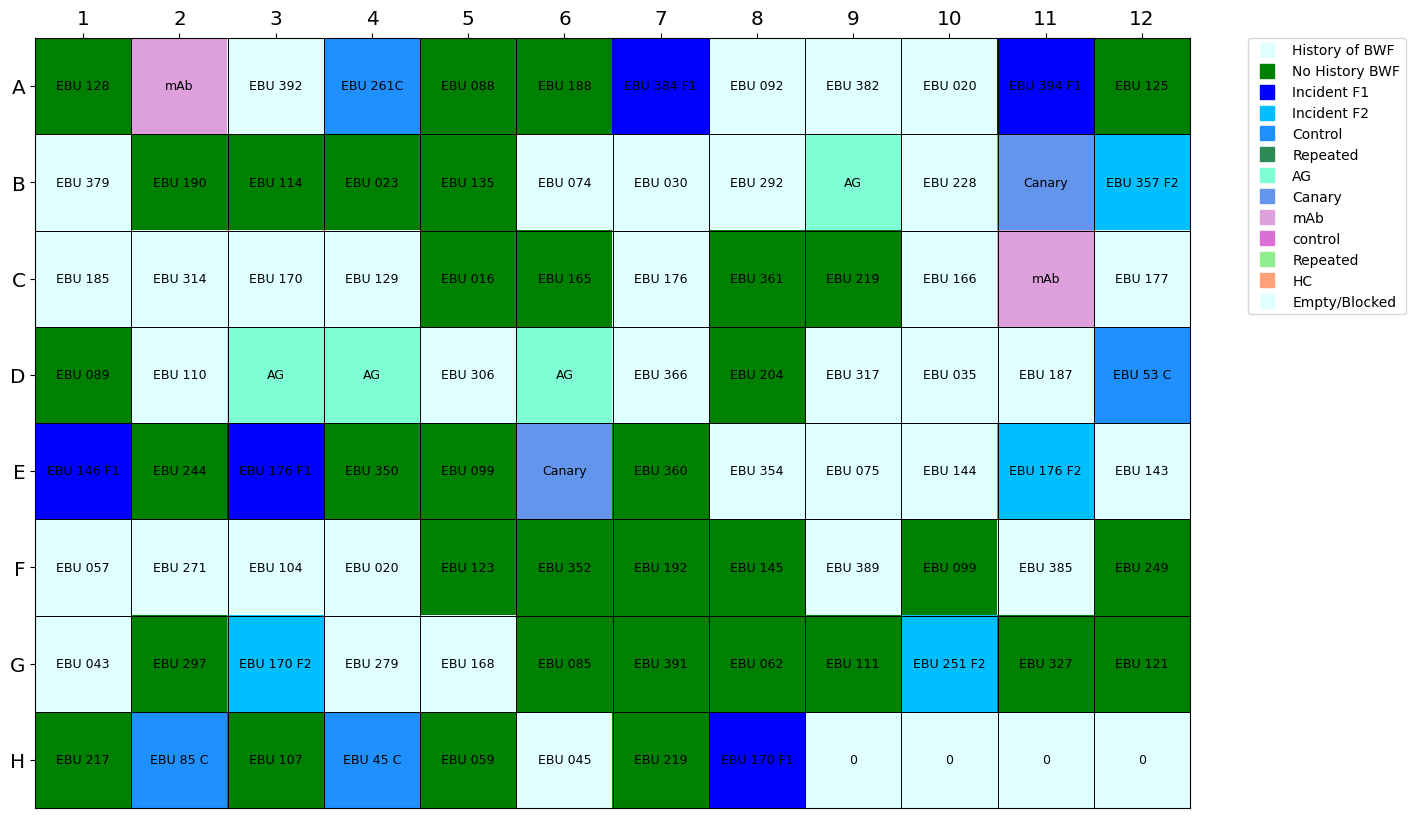

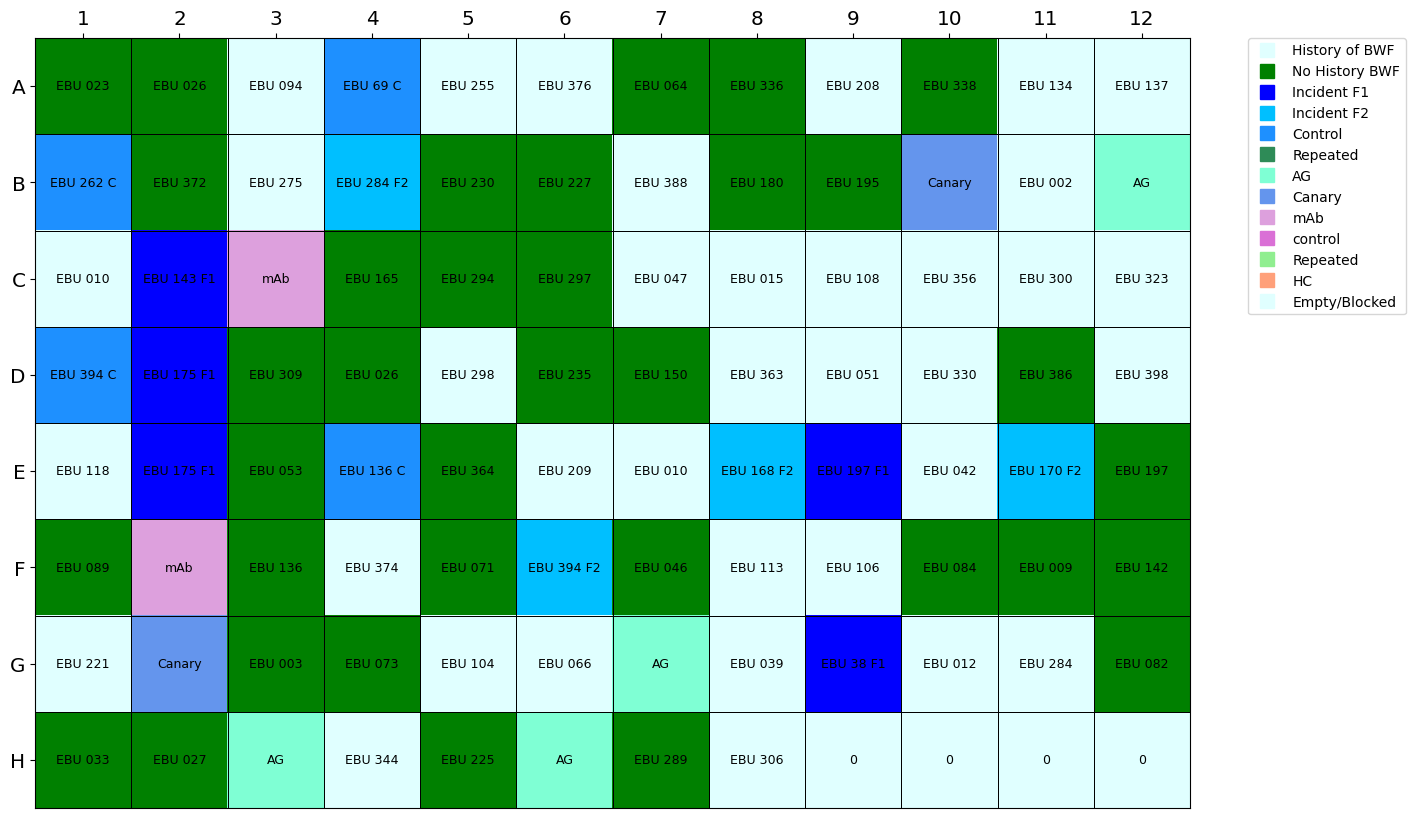

In [15]:
key_dict = {
    "History of BWF": "History of BWF",
    "No history of BWF": "No History BWF",
    "Incident F1": "Incident F1",
    "Incident F2": "Incident F2",
    "control": "Control",
    "Repeated": "Repeated",
}

for pno in sorted(plates):
    print(f"Plate {pno}")
    md.view_plate(plates[pno], view_bin=False, key=True, key_dict=key_dict)

In [6]:
import os 
os.makedirs("./plates_out/", exist_ok=True)
md.save_plates(plates, base_path="./plates_out/")  # writes plate_1.csv, plate_2.csv, ...